Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 25, 12)]          0         
                                                                 
 transformer_block_7 (Transf  (None, 25, 256)          2896640   
 ormerBlock)                                                     
                                                                 
 tf.__operators__.getitem_7   (None, 256)              0         
 (SlicingOpLambda)                                               
                                                                 
 dense_38 (Dense)            (None, 30)                7710      
                                                                 
 dropout_23 (Dropout)        (None, 30)                0         
                                                                 
 dense_39 (Dense)            (None, 1)                 31  

3/3 [==============================] - 0s 7ms/step
[28.1  28.05 30.15 31.55 30.15 30.45 31.3  33.05 34.05 32.25 31.35 32.3
 34.45 32.4  32.5  32.5  32.25 33.2  32.2  32.25 32.   32.3  33.45 31.85
 31.8  31.   31.35 31.85 31.1  30.55 30.55 31.25 30.3  30.35 29.9  29.15
 28.6  29.   30.1  30.85 31.25 30.95 30.8  32.55 33.95 32.8  30.85 31.3
 31.4  31.9  31.75 31.75 31.55 31.25 32.9  33.25 32.65 30.95 30.35 30.55
 31.05 30.1  29.6  29.8  29.35 29.25 29.3  29.65 29.3  29.7  29.35 29.1
 28.25 27.3  26.6  26.2  28.45 29.1  28.6  28.25 28.5  28.1  28.1  28.2
 27.95 27.6  27.4  27.05 27.4  27.6  28.1  27.75 27.85 28.   27.85 27.95]


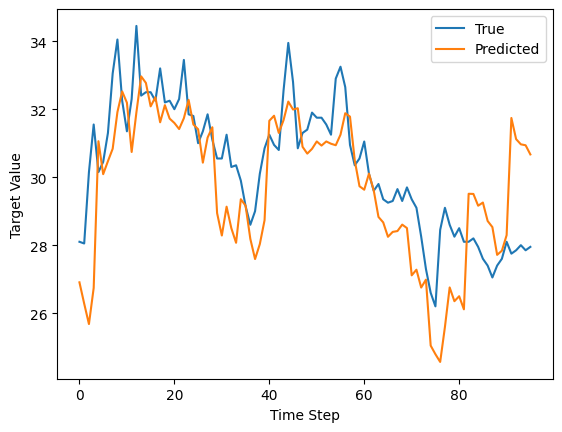

MSE: 2.707115947054634
MAE: 1.2992326796675722
Spearman Correlation: 0.7170674041875975
Directional Symmetry: 50.526315789473685
P-value: 3.212063215303841e-191


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import os
from scipy.stats import spearmanr
from scipy.stats import ttest_ind

def directional_symmetry(y_test, y_pred):
    y_test_diff = np.diff(y_test.flatten())
    y_pred_diff = np.diff(y_pred.flatten())
    y_test_sign = np.sign(y_test_diff)
    y_pred_sign = np.sign(y_pred_diff)
    symmetric = np.sum(y_test_sign == y_pred_sign)
    total = len(y_test_diff)
    symmetry_percentage = (symmetric / total) * 100
    return symmetry_percentage

def calculate_p_value(y_true, y_pred):
    _, p_value = ttest_ind(y_true, y_pred)
    return p_value

def calculate_spearman_correlation(y_true, y_pred):
    correlation, _ = spearmanr(y_true, y_pred)
    return correlation

def preprocess_data(data, features, lookback):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data[features])

    X, y = [], []
    for i in range(lookback, len(data_scaled)):
        X.append(data_scaled[i-lookback:i])
        y.append(data_scaled[i][5])

    X, y = np.array(X), np.array(y)

    X_train, X_test = X[:-96], X[-96:]
    y_train, y_test = y[:-96], y[-96:]

    return X_train, y_train, X_test, y_test, scaler


class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.embedding = Dense(embed_dim, activation='linear')
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        inputs_embedded = self.embedding(inputs)
        attn_output = self.att(inputs_embedded, inputs_embedded)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs_embedded + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


def build_model(embed_dim, num_heads, ff_dim, input_shape, rate=0.1):
    inputs = Input(shape=input_shape)
    x = TransformerBlock(embed_dim, num_heads, ff_dim, rate)(inputs)
    x = Dense(30, activation='relu')(x[:, -1])
    x = Dropout(rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

def plot_predictions(y_test, y_pred):
    plt.plot(y_test, label='True')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time Step')
    plt.ylabel('Target Value')
    plt.legend()
    plt.show()

def main():
    data = pd.read_csv('20MICRONS.csv')
    features = ['Prev Close', 'Open', 'High', 'Low', 'Last', 'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume', '%Deliverble']
    lookback = 25
    embed_dim = 256
    num_heads = 10
    ff_dim = 512

    X_train, y_train, X_test, y_test, scaler = preprocess_data(data, features, lookback)
    model = build_model(embed_dim, num_heads, ff_dim, input_shape=X_train.shape[1:], rate=0.1)
    model.summary()
    epochs = 200
    batch_size = 32
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1)

    y_pred = model.predict(X_test)
    y_pred = y_pred.reshape(-1, 1)  # Reshape y_pred to 2 dimensions
    y_pred = scaler.inverse_transform(np.concatenate([y_pred, np.zeros((y_pred.shape[0], len(features) - 1))], axis=-1))[:, 0]
    y_test_unscaled = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features) - 1))], axis=-1))[:, 0]
    
    print(y_test_unscaled)

    plot_predictions(y_test_unscaled, y_pred)
    print("MSE:", mean_squared_error(y_pred, y_test_unscaled))
    print("MAE:", mean_absolute_error(y_pred, y_test_unscaled))

    spearman_corr = calculate_spearman_correlation(y_test, y_pred)
    print("Spearman Correlation:", spearman_corr)    

    d_symmetry = directional_symmetry(y_test, y_pred)
    p_value = calculate_p_value(y_test, y_pred)

    print("Directional Symmetry:", d_symmetry)
    print("P-value:", p_value)

if __name__ == "__main__":
    main()
